# WIP: sandbox for experiments

In [9]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# This variable should be set to false, unless you are running this notebook without the
# generated datasets
first_time = False

I'm having problems with the pattern

`frame["col"] = new_value`

It always throws warnings, according to SO, it seems to be a viable option to switch the warnings off.
https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'

Remember, we have computed the song word count at three levels of "swear word categories":

In [11]:
offensiveness_rating = pd.read_pickle("../pickles/offensiveness_rating_structured")
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

Now, the problem is that we have tuples as index but we would like to have all these categories in different columns. So we do some processing to take care of that:

In [12]:
def process_tuple(t):
    
    def process_tuple_elem(elem):
        if elem == "nan":
            return np.nan
        else:
            return elem[1:-1]
    return list(map(process_tuple_elem, t[1:-1].replace(" ", "").split(",")))
index_offensiveness = list(map(process_tuple, offensiveness_rating.index.tolist()))

In [13]:
value_offensiveness = list(offensiveness_rating.values)

In [14]:
data_non_flat = list(zip(index_offensiveness, value_offensiveness))

In [15]:
columns = ["track_id", "category", "strength", "target", "value"]
track_off = pd.DataFrame.from_records([elem[0] + [elem[1]] for elem in data_non_flat], columns=columns)
track_off = track_off.set_index(["track_id", "category", "strength", "target"])
track_off.head()

value
track_id           category           strength target       
TRAAAAV128F421A322 non-discriminatory mild     NaN         1
                   NaN                NaN      NaN       102
TRAAABD128F429CF47 NaN                NaN      NaN       226
TRAAAED128E0783FAB NaN                NaN      NaN       421
TRAAAEF128F4273421 NaN                NaN      NaN       139

That's it, we have our multi-index structure. Now, we have the choice: absolute or relative count of swear words in a song ? This choice is rather difficult. But, in some way, even if a song is longer than another one, we can (for now) consider that simply having more swear words is equivalent to being more vulgar. So let's simply count the number of swear words per song:

In [16]:
%%time 
if first_time:
    track_offensiveness = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
    track_offensiveness = track_offensiveness.fillna(0)
    track_offensiveness.to_csv("../datasets/track_offensiveness.csv")
else:
    track_offensiveness = pd.read_csv("../datasets/track_offensiveness.csv", header=None)

Wall time: 112 ms


And here is our frame relating a song with its offensiveness (so, for example, the song with track ID 'TRAAAAV128F421A322' contains one swear word)

In [17]:
track_offensiveness.columns=["track_id", "offensiveness"]
track_offensiveness.head()

,track_id,offensiveness
0,TRAAAAV128F421A322,1.0
1,TRAAABD128F429CF47,0.0
2,TRAAAED128E0783FAB,0.0
3,TRAAAEF128F4273421,0.0
4,TRAAAEW128F42930C0,0.0


We take only the columns we are interested in:

In [18]:
song_info = pd.read_csv("../datasets/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]
song_info.head()

,track_id,genre,song_hotness,song_id,title,year
0,TRBEEBA128F9354588,NaN,NaN,SOKZDUY12AC9E12A16,(Sweat_ Sweat),2007
1,TRBEEYF128EF34152F,NaN,NaN,SOEEDAK12A67AE2142,Heavenly (Instrumental Dub),0
2,TRBEEME128F42274E2,NaN,NaN,SOLVIJZ12A6D4FC406,In The Right Way,2000
3,TRBEENM12903CDA90A,NaN,0.51876,SOKLANA12A8C14016F,Hacha Y Machete,1976
4,TRBEETN128F4290E24,NaN,NaN,SOLODJD12A8C139CE3,Bus Stop,1968


### English songs
We now want to do our analysis for english songs only so we read the corresponding track IDs. The process of "detecting" which songs are in english is described in [this notebook](handling_languages.ipynb).

In [19]:
english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1]
print("We have {} english songs.".format(english_songs.shape[0]))
english_songs = english_songs.to_frame()
english_songs.columns = ["track_id"]
english_songs.head()

We have 202115 english songs.


,track_id
0,TRAAAAV128F421A322
1,TRAAABD128F429CF47
2,TRAAAED128E0783FAB
3,TRAAAEF128F4273421
4,TRAAAEW128F42930C0


In [20]:
english_songs.columns

Index(['track_id'], dtype='object')

In [21]:
track_offensiveness.columns

Index(['track_id', 'offensiveness'], dtype='object')

In [22]:
english_track_offensiveness = english_songs.merge(track_offensiveness, on="track_id")
print("We have {} songs.".format(english_track_offensiveness.shape[0]))
english_track_offensiveness.columns = ["track_id", "abs_offensiveness"]
english_track_offensiveness.head()

We have 202115 songs.


,track_id,abs_offensiveness
0,TRAAAAV128F421A322,1.0
1,TRAAABD128F429CF47,0.0
2,TRAAAED128E0783FAB,0.0
3,TRAAAEF128F4273421,0.0
4,TRAAAEW128F42930C0,0.0


In [23]:
song_info_offensiveness = song_info.merge(english_track_offensiveness.reset_index(), on="track_id")
song_info_offensiveness = song_info_offensiveness.rename(columns={0: "abs_offensiveness"})
song_info_offensiveness.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
0,TRBEEGF128F42AB67E,NaN,0.000000,SOMYKOX12A8C13D59F,Collision Course,0,9341,0.0
1,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0
2,TRBEEEA128F92E7EED,NaN,NaN,SOGLPMS12D02193D69,Fake Messiah (Album Version),2009,9339,0.0
3,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0
4,TRBEEXV128F93116C9,NaN,0.227736,SOJHHMQ12AB017C6A6,Don't Ya Ever Leave Me (Live),0,9348,0.0


That's good, we have more than 200000 english songs with absolute offensiveness value. The two other values we will be the most focused on are the song hotness and the year. So we need to keep those where the year is not 0 and the song hotness is not nan. For now, let's proceed by keeping only datapoints with positive hotness value.

### Combine with play counts

In [24]:
songs_counts=pd.read_csv("../datasets/songs-counts.csv")
songs_counts.head()

,songs,counts
0,SOAAADD12AB018A9DD,24
1,SOAAADE12A6D4F80CC,12
2,SOAAADF12A8C13DF62,9
3,SOAAADZ12A8C1334FB,12
4,SOAAAFI12A6D4F9C66,188


In [25]:
songs_counts.columns=["song_id", "counts"]

In [26]:
songs = song_info_offensiveness.merge(songs_counts, on="song_id")
songs.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts
0,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0,227
1,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0,1168
2,TRBEEZO12903D05259,NaN,0.520345,SOUDWTU12AC37746F7,Spade and Parade,1994,9350,1.0,68
3,TRBEEEO128F146B9F1,NaN,NaN,SOPGDTB12A6D4F740A,Driving With The Brakes On,1995,9340,0.0,191
4,TRBEEYL128F1491A39,NaN,NaN,SOLTMAH12A6D4FA0B3,Making Waves (2003 Digital Remaster),2002,9349,0.0,13


In [27]:
songs.to_csv("../datasets/songs.csv")

## Looking at simple correlations between offensiveness, hotness, counts and year

In [28]:
# select the values we want to have
off_hot_year = songs[["song_hotness", "year", "abs_offensiveness", "counts"]]

# for this superficial analysis, we clean the data aggressively
off_hot_year = off_hot_year.query("year > 0")
off_hot_year = off_hot_year.query("counts > 1")

In [29]:
off_hot_year.corr()

,song_hotness,year,abs_offensiveness,counts
song_hotness,1.000000,0.186625,-0.006918,0.129653
year,0.186625,1.000000,0.016476,0.020274
abs_offensiveness,-0.006918,0.016476,1.000000,0.004138
counts,0.129653,0.020274,0.004138,1.000000


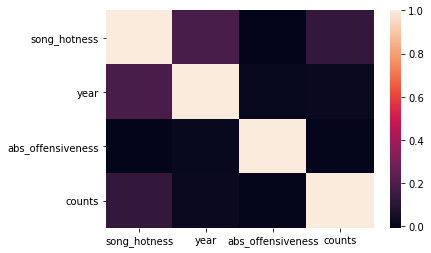

In [30]:
corr = off_hot_year.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Looking at correlations: Discussion
We don't see any correlation. This was a very superficial analysis. In a next step we will try to go into more detail

## Applying filtering and smoothing
Correlation is a very simple tool which only looks for linear dependancies. For the raw data, we don't see any correlations. But this doesn't mean that there is no connection. A simple explanation would be that we need to apply more data cleaning. This is what we will do now:
 - apply a variety of filtering operations to find correlations in subsets of the data.
 - try to smooth the data


In [31]:
# smoothing the counts by using their log
offensiveness_counts = songs[["song_hotness", "year", "abs_offensiveness", "counts"]]

offensiveness_counts_log = offensiveness_counts.copy()
offensiveness_counts_log["counts"] = offensiveness_counts_log["counts"].apply(lambda x : np.log(x))
offensiveness_counts_log.corr()

,song_hotness,year,abs_offensiveness,counts
song_hotness,1.000000,0.217558,-0.012522,0.508213
year,0.217558,1.000000,-0.039431,0.112978
abs_offensiveness,-0.012522,-0.039431,1.000000,0.013263
counts,0.508213,0.112978,0.013263,1.000000


In [32]:
# looking only at songs that have been played often
offensiveness_counts_popular = offensiveness_counts_log.query("counts> 3")
offensiveness_counts_popular.corr()

,song_hotness,year,abs_offensiveness,counts
song_hotness,1.000000,0.178415,-0.019310,0.433320
year,0.178415,1.000000,-0.037461,0.051465
abs_offensiveness,-0.019310,-0.037461,1.000000,0.015510
counts,0.433320,0.051465,0.015510,1.000000


In [33]:
# looking only at recent songs
offensiveness_counts_recent = songs.query("year > 1990")[["abs_offensiveness", "counts"]]
offensiveness_counts_recent.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.005394
counts,0.005394,1.000000


In [34]:
# looking only at very recent songs
offensiveness_counts_very_recent = songs.query("year > 2000")[["abs_offensiveness", "counts"]]
offensiveness_counts_very_recent.corr()

,abs_offensiveness,counts
abs_offensiveness,1.000000,0.007334
counts,0.007334,1.000000


### Filtering and smoothing: Discussion

This doesn't give us any information either. The evaluations I have included above are just a selection of tests. I have tried a variety of filters and smoothings.

Unfortunately, I couldn't find any significant result. This doesn't mean that there is no dependence between the data points, but it does seem as if there is no linear dependence.

Next, we need to take a step back. Correlation uses a linear model to explain the data, this is not powerful enough. Before we try fitting a more complex model, we should investigate the data and make a principled decision.


## Looking at the data directly

Sometimes, scatter plots can be an effective tool to show structure in the data. These plots have to be used with caution: The scatter plots I'm using are not heatmaps, they give no intuition for the density of the data.

The results could be misleading, they are only meant to provide idea for the models to fit to the data.

## Scatter years and offensiveness

This seems to show that songs become more offensive over time.

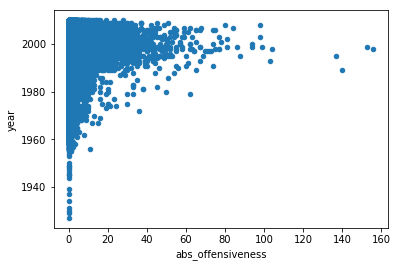

In [35]:
songs[songs["year"]>0].plot.scatter("abs_offensiveness", "year")

## Scatter offensiveness and play counts

This seems to show that play counts actually decrease with offensiveness.

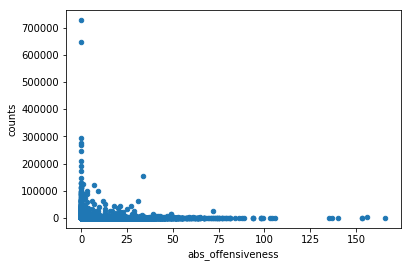

In [36]:
songs.plot.scatter("abs_offensiveness", "counts")

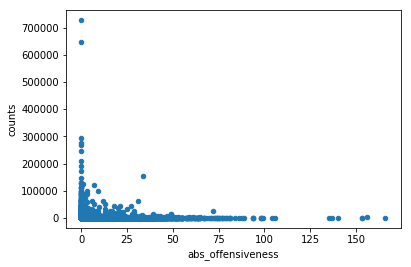

In [37]:
songs.query("counts > 1").plot.scatter("abs_offensiveness", "counts")

## Scatter offensiveness and hotness

We have to filter the hotness a lot.

This is actually the most interesting plot, I think.
It seems that "average" songs are the most offensive.

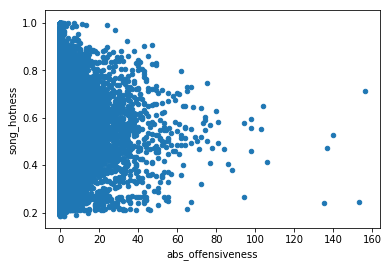

In [38]:
songs[["song_hotness", "abs_offensiveness"]]\
    .dropna()\
    .query("song_hotness > 0.1")\
    .plot.scatter("abs_offensiveness", "song_hotness")

## Scatter plots: Intermediate Discussion

There seems to be some structure in the data.

Intuitively, I think the problem is that these trends are driven by a small subset of data points.
The outliers have some structure, the mass in center is useless.

Maybe we should just look at the development of offensive songs. I've filtered out songs of low offensiveness and am repeating the plots from above. The result is the same.


In [42]:
# for the songs that are offensive, what values do we see
songs.query("abs_offensiveness >= 1").describe()

,genre,song_hotness,year,index,abs_offensiveness,counts
count,0.0,22544.000000,26207.000000,26207.000000,26207.000000,26207.000000
mean,NaN,0.542212,1602.315832,101354.288434,4.601175,539.737856
std,NaN,0.174127,798.014516,58148.651360,8.222534,2884.665691
min,NaN,0.000000,0.000000,0.000000,1.000000,1.000000
25%,NaN,0.458675,1985.000000,50938.000000,1.000000,16.000000
50%,NaN,0.563359,1999.000000,102256.000000,2.000000,63.000000
75%,NaN,0.656220,2005.000000,151720.500000,4.000000,278.000000
max,NaN,1.000000,2010.000000,202112.000000,166.000000,155717.000000


In [56]:
# so 50% of the offensive songs actually contain only <= 2 offensive words.
# we might want to exclude that
filtered_songs = songs.query("abs_offensiveness >= 2")

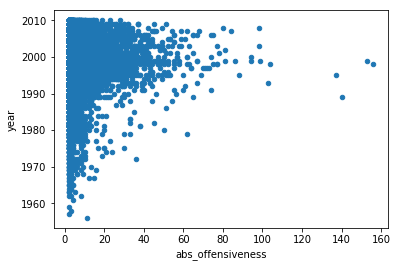

In [57]:
filtered_songs.query("year > 0").plot.scatter("abs_offensiveness", "year")

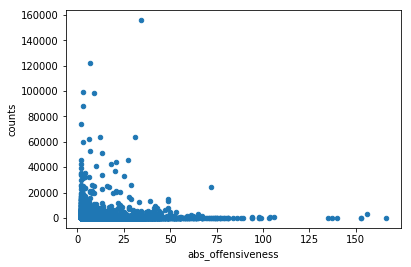

In [58]:
filtered_songs.plot.scatter("abs_offensiveness", "counts")

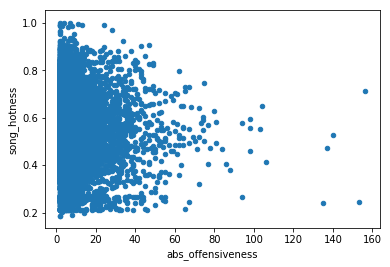

In [59]:
filtered_songs[["song_hotness", "abs_offensiveness"]]\
    .dropna()\
    .query("song_hotness > 0.1")\
    .plot.scatter("abs_offensiveness", "song_hotness")

# Discussion

The scatter plots from above give two insights:
 - The number of offensive songs seems to increase over time
 - Songs of average hotness are more offensive than songs of high or low hotness
 
As said above: scatterplots are not a good tool to get solid results. This is just an intuition and needs to be verified.

We will now construct metrics that we can plot over time.

In [60]:
# playcounts of offensive vs non-offensive songs
songs_binary = songs.copy()
songs_binary["offensive"] = songs_binary["abs_offensiveness"].apply(lambda x : x>0)
songs_binary.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts,offensive
0,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1.0,227,True
1,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0.0,1168,False
2,TRBEEZO12903D05259,NaN,0.520345,SOUDWTU12AC37746F7,Spade and Parade,1994,9350,1.0,68,True
3,TRBEEEO128F146B9F1,NaN,NaN,SOPGDTB12A6D4F740A,Driving With The Brakes On,1995,9340,0.0,191,False
4,TRBEEYL128F1491A39,NaN,NaN,SOLTMAH12A6D4FA0B3,Making Waves (2003 Digital Remaster),2002,9349,0.0,13,False


In [61]:
songs_binary = songs_binary[["year", "counts", "offensive"]]

In [62]:
songs.query("year >= 2000 and abs_offensiveness >= 1").shape

(12865, 9)

In [63]:
# the first occurence of an offensive song is
first_year = songs_binary.query("offensive == True and year > 0")["year"].min()
print("first occurence of an offensive song (in our data): "+str(first_year))

# creating query strings
offensive_query = "year > {0} and offensive == True".format(first_year)
not_off_query = "year > {0} and offensive == False".format(first_year)

# getting play counts
of_counts = songs_binary.query(offensive_query).groupby("year").agg("sum")["counts"]
no_counts = songs_binary.query(not_off_query).groupby("year").agg("sum")["counts"]

# calculating ratio
ratio = of_counts / (of_counts + no_counts)
ratio.head()

first occurence of an offensive song (in our data): 1955


year
1956    0.359954
1957    0.445140
1958    0.052062
1959    0.133210
1960    0.015698
Name: counts, dtype: float64

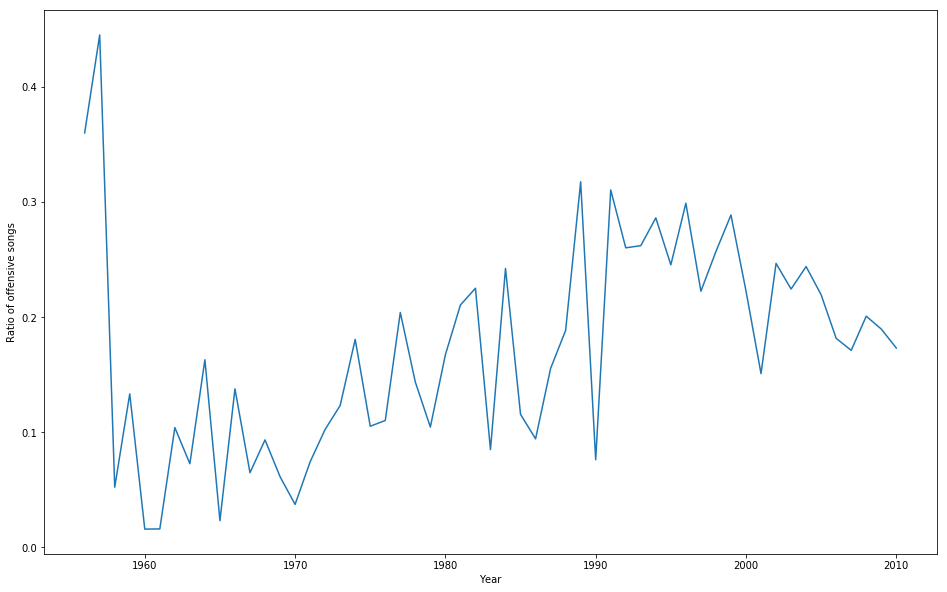

In [75]:
plt.figure(figsize=(16, 10))
plt.xlabel("Year")
plt.ylabel("Ratio of offensive songs")
plt.plot(ratio)
plt.show()

Still not saying something useful. Let's try another method: we will simply count the total number of swear words per year.

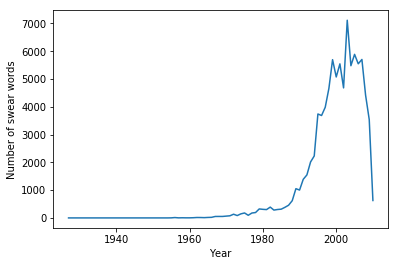

In [78]:
to_plot_total_off_vs_year = songs[["year", "abs_offensiveness"]].query("year > 0").groupby(by="year")
plt.figure()
plt.xlabel("Year")
plt.ylabel("Number of swear words")
plt.plot(to_plot_total_off_vs_year.sum())
plt.show()

We see that the total number of swear words goes up as year increases but this is normal because more songs implies more words. But let's see what we get if we divide that number by the number of songs (which would be the average number of swear words per song)

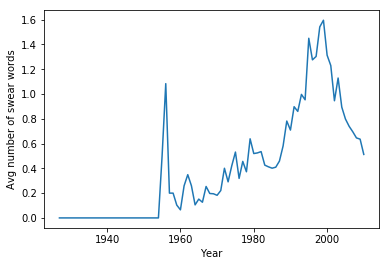

In [79]:
year_avg_off = to_plot_total_off_vs_year.apply(lambda frame: frame["abs_offensiveness"].sum() / frame.shape[0])
plt.figure()
plt.xlabel("Year")
plt.ylabel("Avg number of swear words")
plt.plot(year_avg_off)

Ok so we start seeing something interesting here: the average number of swear words per song is the highest somewhere around the year 2000 ! The year 1956 seems strangely more offensive than the others. Let's take a closer look:

In [25]:
songs.query("year==1956")

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness,counts
334,TRBMFFE12903CD8DBB,NaN,0.565451,SOVAJRE12AAF3B5D75,All Around the World,1956,11709,0.0,43
7202,TRKTSXR128F92D450C,NaN,0.527703,SORRERJ12A8C1423B4,Little Darlin',1956,84075,0.0,10
40638,TRUGFZM12903CC04E3,NaN,NaN,SOEWGGU12A8C133950,Love Me,1956,157794,0.0,1590
54930,TRCTNHQ128F92FA33F,NaN,0.651224,SOXQVNW12AAF3B2DBC,Need Your Love So Bad,1956,21630,0.0,180
57321,TRZMZTY128F1499425,NaN,NaN,SOIHGSM12A6D4FA0A6,Tenderly,1956,198369,0.0,264
70122,TREFXXT128F92F0CD5,NaN,0.616153,SOJFEXC12A8C142F91,Who Needs You,1956,33320,0.0,23
70891,TRESXGW128F426425A,NaN,NaN,SOVZKUJ12A58A7DAB7,Down Home Special,1956,37103,1.0,14
73127,TRXZLKU128F1462813,NaN,0.328609,SOSXZVJ12A6D4F6CB4,Oh_ Marie (2002 Digital Remaster),1956,186537,0.0,48
84223,TRQKNVC12903CB0448,NaN,0.618166,SODSPJZ12A8AE47A81,Bad Luck,1956,128172,1.0,249
87420,TRWXAZN128F426D7B5,NaN,NaN,SOFGKOE12A58A7DB22,Honey Chile,1956,178189,0.0,41


We see the song "Smokestack Lightning" here which seems to have 11 offensive words. Here are the lyrics:

Ah oh, smokestack lightnin'
Shinin', just like gold
Why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa oh, tell me, baby
What's the, matter with you?
Why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa oh, tell me, baby
Where did ya, stay last night?
A-why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa-oh, stop your train
Let her, go for a ride
Why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa-oh, fare ya well
Never see, a you no more
A-why don't ya hear me cryin'?
Whoo hoo
Whoo hoo
Whoo
Whoa-oh, who been here baby since,
I-I been gone, a little, bitty boy
Girl, be on
Whoo hoo
Whoo hoo
Whoo

There are absolutely no swear words here but, taking a closer look at our MusixMatch dataset we see that the word "hoo" was inserted as "ho" and it appears 11 times in MusixMatch. This is a problem but it is due to the dataset and we can't do much about it  (apart from trying to do some intense nlp which won't work anyway). But anyway, this is not a recurrent problem so we don't need to do worry too much about this. The only annoying thing is that, because of this, and because of the fact that there are only 12 songs for 1956, we get that the average number of swear words is 13 / 12 = 1.08. Fortunately, the number of songs becomes bigger and bigger over time so this problem becomes negligeable.

Let's get back to our offensiveness per year plots. Last method showed something like an increase of the average number of swear words over time and a decrease somewhere after the year 2000. But let's come back to our idea of ratio between the number of offensive vs non offensive songs. Maybe taking 1 as a threshold is not a good idea. Actually it is rather subjective at what swear words count someone will consider a song as offensive. So let's try to redo our ratio method but including thresholds:

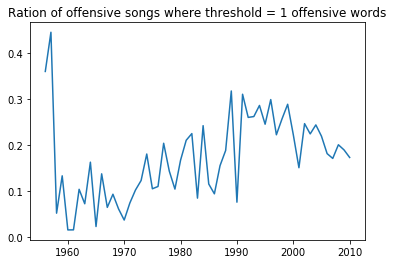

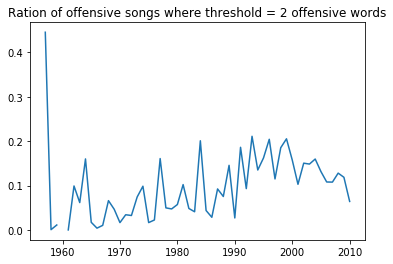

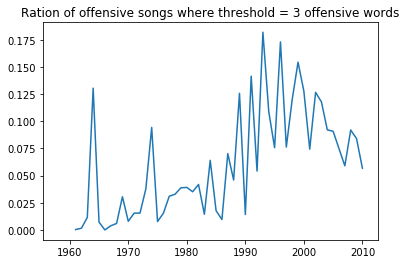

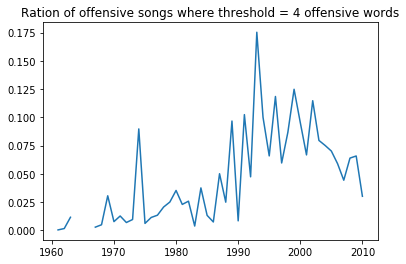

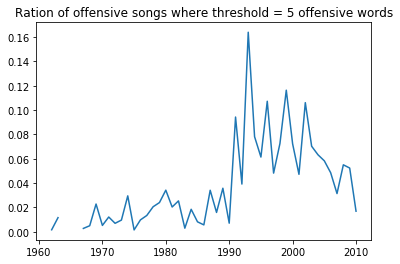

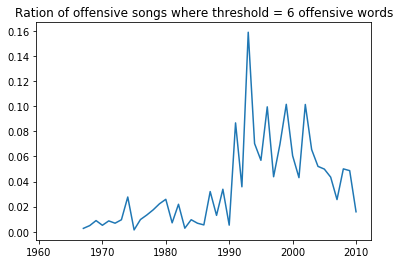

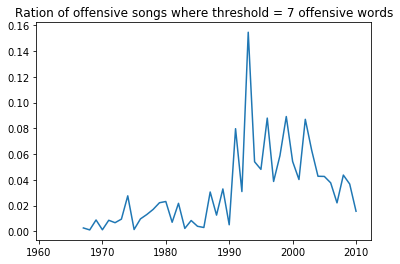

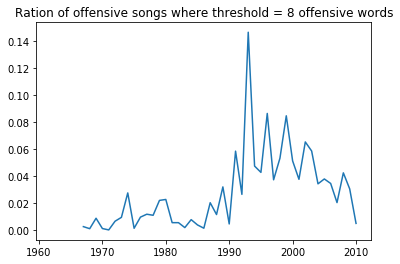

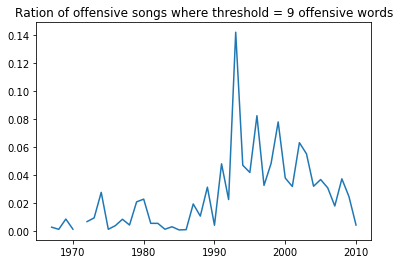

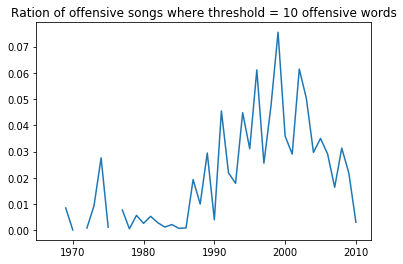

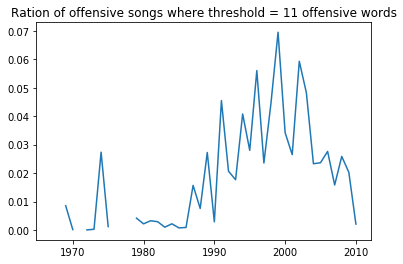

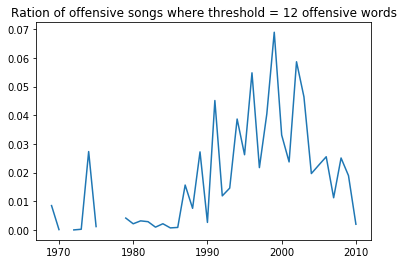

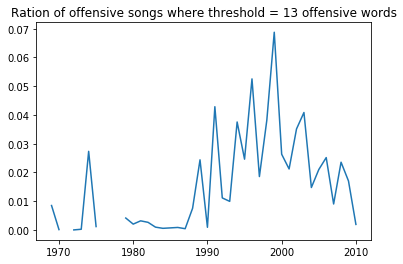

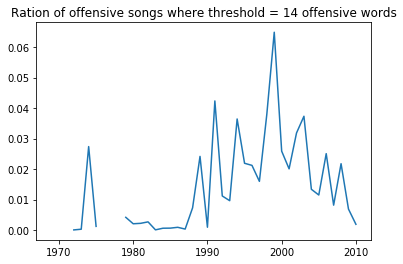

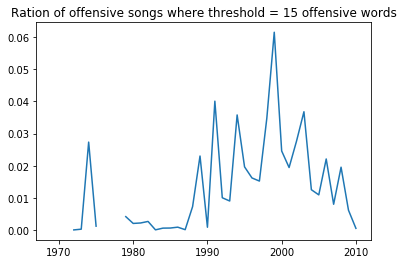

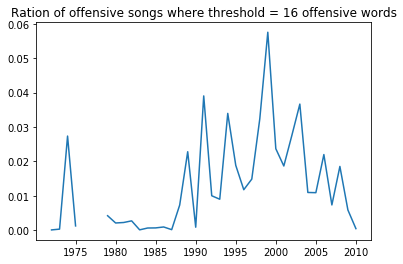

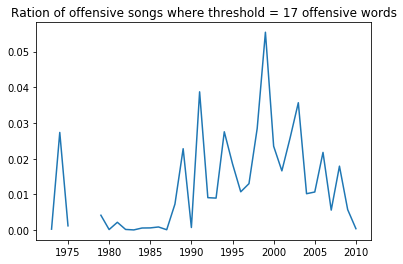

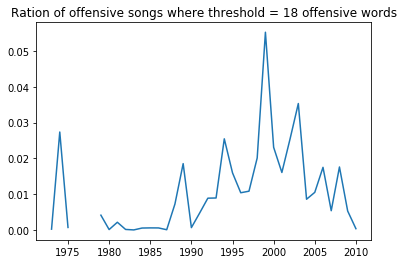

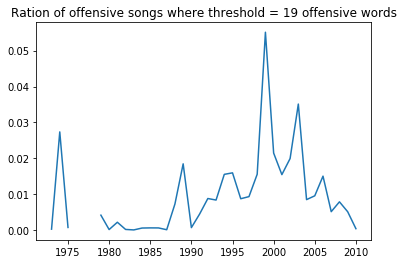

In [67]:
def ratio_offensiveness_year(threshold=1, show_plot=True):
    songs_binary = songs.copy()
    songs_binary["offensive"] = songs_binary["abs_offensiveness"].apply(lambda x : x>=threshold)

    songs_binary = songs_binary[["year", "counts", "offensive"]]
    first_year = songs_binary.query("offensive == True and year > 0")["year"].min()

    offensive_query = "year > {0} and offensive == True".format(first_year)
    not_off_query = "year > {0} and offensive == False".format(first_year)

    of_counts = songs_binary.query(offensive_query).groupby("year").agg("sum")["counts"]
    no_counts = songs_binary.query(not_off_query).groupby("year").agg("sum")["counts"]

    ratio = of_counts / (of_counts + no_counts)
    if show_plot:
        plt.figure()
        plt.title("Ration of offensive songs where threshold = {} offensive words".format(threshold))
        plt.plot(ratio)
        plt.show()
    else:
        plt.plot(ratio, label="threshold={}".format(threshold))

for i in range(1, 20):
    ratio_offensiveness_year(i)

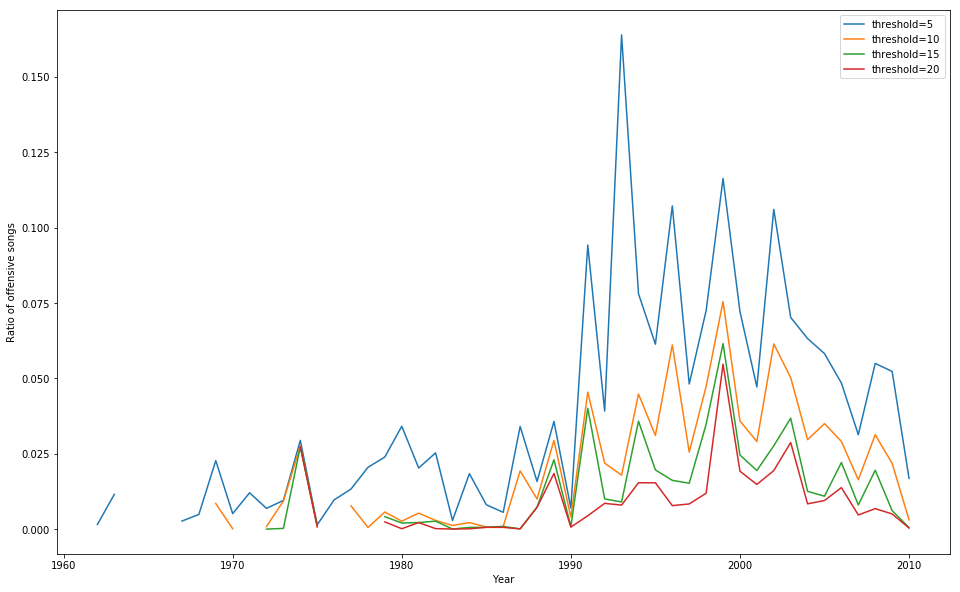

In [73]:
plt.figure(figsize=(16, 10))
plt.xlabel("Year")
plt.ylabel("Ratio of offensive songs")
for i in [5, 10, 15, 20]:
    ratio_offensiveness_year(i, False)
plt.legend()
plt.show()

So, as we increase the threshold, we get approximately to the same idea we had with the average number of swear words per song: the most offensive songs are located somewhere in the 1990 - 2000 decade and the trend is kept alive after that (with less intensity). Let's take a closer look at the most offensive songs:

In [92]:
most_offensive_songs = songs.sort_values("abs_offensiveness", ascending=False)[["title", "year", "abs_offensiveness", "song_hotness", "counts"]].head(12)
most_offensive_songs

,title,year,abs_offensiveness,song_hotness,counts
366,Don't Gimme No H.A.N./?,0,166.0,NaN,38
48862,Gangster Tripping,1998,156.0,0.711211,3326
35579,Down For My N's,0,153.0,0.246865,65
16525,Bitch Niggas,1999,153.0,NaN,58
9374,Roll Call,1989,140.0,0.528782,138
111983,Can't Tell Me Shit,1995,137.0,0.471971,26
20864,Booty Man (Remix),0,135.0,0.239629,135
117722,Stop Fuckin Wit Me,0,106.0,0.415050,443
55122,Acid 8000,1998,104.0,0.648113,424
54597,Lose A Hoe_ Gain A Hoe,1993,103.0,0.552007,1


In [93]:
with open('report/tables/most_offensive_songs.tex','w') as tf:
    tf.write(most_offensive_songs.to_latex(index=False))


This confirms our intuition. If we look at the top songs the majority of them (at least those where we have the year) seem to belong somewhere in the decade 1990 - 2000 (or around that decade - "Roll Call" is in 1989. This is not really a surprise since street rap music was on the rise back then. Rappers were even involved in clan shootings and they were writing their songs in a pretty dangerous environment (Tupac, one of the most famous rappers, was killed in a shooting in 1996 for example).

If we look at the lyrics of those songs we see that they are almost hilarious: maybe one word out of two is a swear word. For example, here is the chorus of the song "Bitch Niggaz" from Snoop Dogg and Dr. Dre

## Machine learning

None of the approaches above seem to reveal any data.

We will now try to apply a more powerful method. Instead of linear regression (correlation), or hand-crafted features, we use a multilayer perceptron to search for structure with a machine learning approach

### Step 1: convert dataframe to numpy array

We chose keras for the machine learning, it works on numpy arrays.
We also apply smoothing to the data

In [56]:
data_frame = songs.query("year>0").query("counts > 1").query("song_hotness<=1") [["year", "counts", "abs_offensiveness"]]
data_frame.head()

,year,counts,abs_offensiveness
2,1994,68,1.0
6,1992,316,0.0
7,2001,787,0.0
8,2003,1017,0.0
9,1995,79,0.0


In [57]:
# smoothing the data
data_frame["abs_offensiveness"]= data_frame["abs_offensiveness"].apply(lambda x: np.log(x) if x > 0 else x)
data_frame["counts"]= data_frame["counts"].apply(lambda x: np.log(x) if x > 0 else x)

In [58]:
data_frame.describe()

,year,counts,abs_offensiveness
count,86194.000000,86194.000000,86194.000000
mean,1999.662401,4.412470,0.166196
std,9.101687,1.913043,0.547155
min,1927.000000,0.693147,0.000000
25%,1996.000000,2.995732,0.000000
50%,2003.000000,4.317488,0.000000
75%,2006.000000,5.733341,0.000000
max,2010.000000,13.496524,5.049856


In [59]:
data = data_frame.values
data.shape

(86194, 3)

In [60]:
np.random.shuffle(data)

### Splitting into train, val, test

In [61]:
num_samples = data.shape[0]
X = data.copy()[:, :2].astype(np.float32)
y = data.copy()[:, 2].astype(np.float32)

In [62]:
X -= X.min(axis=0)
y -= y.min()

In [63]:
X /= X.max(axis=0)
y /= y.max()

In [64]:
train_split = int(num_samples*0.6)
test_split =  int(train_split + num_samples * 0.2)

X_train = X[:train_split]
y_train = y[:train_split]

X_test = X[train_split : test_split]
y_test = y[train_split : test_split]

X_val = X[test_split : ]
y_val = y[test_split : ]

### Setup and training of the model

In [65]:
import keras

from keras.models import Sequential
from keras.layers import Input, Dense, Activation

ImportError: No module named 'keras'

In [66]:
model = Sequential()
model.add(Activation(input_shape=(2, ), activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="mean_squared_error", optimizer="adam")

NameError: name 'Sequential' is not defined

In [67]:
# the training is very fast
# this is not surprising, we only have 80000 data points and they are only 2 values, each
history = model.fit(X_train, y_train, verbose=2, epochs = 5)

NameError: name 'model' is not defined

In [422]:
# checking scores on test set,
# we get similar results, so there doesn't seem to be any overfitting
model.evaluate(X_test, y_test)

16832/17238 [============================>.] - ETA: 0s

0.01145130886521987

### Let's feed the model with some sample data

We want to see how offensiveness evolves over time.
We have seen above that popularity seems to have little influence on it.

So we plot a series of curves. They are the predicted offensiveness of a song with given popularity, over time.

In [429]:
predictions = []

for i in range(10):
    feed = np.zeros((50, 2))
    feed[:, 0] = np.linspace(0, 1, 50)
    popularity = i/10
    feed[:, 1] = popularity

    predictions.append((model.predict(feed), popularity))

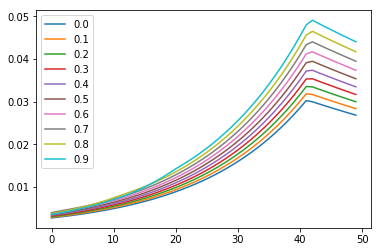

In [433]:
plt.figure()

for prediction, popularity in predictions:
    plt.plot(prediction, label=popularity)
    
plt.legend()
plt.show()